# VAE

- Crear Data Loader Dividir la data 80% - 10% - 10%  Utilizando clase DataLoader Pytorch
- Visualizar Imagenes 8 x 8 para comprar simulacion real y simulacion generada
- Normalizar Base de datos entre [-1 , 1]
- Autoencoder con CNN o MLP  - VAE con CNN o MLP
- Validar mediante dimensionalidad
- Entrenar y Generar Graficos Loss Train - Loss Validation - Loss Test
- Visualizar resultados

Se realizaron 200 Simulaciones con parametros constitutivos aleatorios para el modelo Holzapfel 2015, las simulaciones se realizaron en 200 pasos donde se guardaron desde el 50 hasta el final, por lo cual se poseen $151 \cdot 200 = 30200$ "Imagenes" Cada simulacion posee 7701 nodos. 

# Verficar Datos

primero se revisa que los datos utilizados correspondan al ensayo de presurizacion 

In [14]:
from torch.utils.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
import pyvista as pv
from Funciones_utiles import *
it = 1
data_file = '/media/nicolas/DiscoDuro/Tesis/Presurizacion_Holza/Desplazamientos_Presurizacion_holza2_' + str(it) + '.npz'
u  = np.load(data_file)['arr_0']
u_test  = u.reshape((-1,2,151)) 

#Se verifica que la simulacion este bien
malla = pv.read('/home/nicolas/Escritorio/Codigos/python/VAE/mallas/ArteriaPrs.msh')
malla.clear_data()
#Guardar_Gif_Malla(malla, u_test )



# Algoritmo para vizualisar el ensayo como una imagen

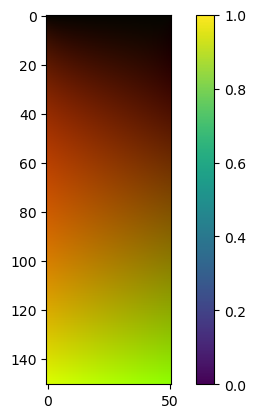

In [15]:
import numpy as np
import matplotlib.pyplot as plt
puntos = malla.points
in_indices = np.lexsort((puntos[:, 0], puntos[:, 1]))
out_indices =  np.argsort(in_indices)
#u_prueba = u[:,150]
u_prueba_2D = u[:,150].reshape(-1,2)
# u_prueba_2D_2  = u_prueba_2D[in_indices]
# u_prueba = u_prueba_2D_2.reshape(-1)

u_prueba = u[:, 150].reshape(-1, 2)[in_indices].reshape(-1)


maximo , minimo = np.max(u_prueba) , np.min(u_prueba)
u_prueba_normalized = (u_prueba - minimo  ) / (maximo - minimo) #u_prueba_2D 
#u_prueba_normalized =  u_prueba_normalized.reshape((-1,2))


image  = DATOS_TO_imagen(u_prueba_normalized)
#image = np.transpose(image,(2,0,1))
#print(np.transpose(image,(2,0,1)).shape)
# Mostrar la imagen utilizando matplotlib
plt.imshow(image)
plt.colorbar()
#imagen_pillow = Image.fromarray((image* 255).astype('uint8'))
#imagen_pillow.save('imagen_guardada.png')

#img.imsave('prueba.png',image)


In [3]:
normalized_data_out = IMAGEN_TO_data(image)
normalized_data_out = normalized_data_out
data_out = (maximo - minimo) * normalized_data_out  + minimo
data_out = data_out.reshape(-1,2)[out_indices]

malla_deformada(malla,data_out)

Widget(value="<iframe src='http://localhost:35671/index.html?ui=P_0x7f555fc93af0_0&reconnect=auto' style='widt…

In [4]:
malla_deformada(malla,u_prueba_2D)

Widget(value="<iframe src='http://localhost:35671/index.html?ui=P_0x7f555fc93f10_1&reconnect=auto' style='widt…

# Manejo de Datos

Se busca realizar una gran matriz 2D con todos los datos de las simulaciones de esta manera si desea crear un AutoEncoder o una VAE convolucional o Fully conected se posean todos los datos en una misma gran matriz 2D de snaptchots.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os

data_rute = '/media/nicolas/DiscoDuro/Tesis/Presurizacion_Holza/'

nombres_archivos = os.listdir(data_rute)

nombres_desplazamientos = []
numero_simulacion = []
for  i in nombres_archivos:
    if i[0] == 'D':
        nombres_desplazamientos.append(i)
        numero_simulacion.append(int(i.split('_')[-1].split('.')[0]))


indices_ordenados = np.argsort(numero_simulacion).astype(int)
nombres_desplazamientos = [nombres_desplazamientos[i] for  i in  indices_ordenados ]
        

In [36]:
Snaptchots_Matrix = np.load(data_rute + nombres_desplazamientos[0])['arr_0']

for i in nombres_desplazamientos[1:]:
    aux = np.load(data_rute + i)['arr_0']
    Snaptchots_Matrix = np.concatenate((Snaptchots_Matrix, aux), axis=1)


np.savez_compressed('Snaptchot_Matrix.npz',Snaptchots_Matrix)

# Se guardan las imagenes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from Funciones_utiles import *
Matriz_S  = np.load('Snaptchot_Matrix.npz')['arr_0']
columnas_con_nan = np.any(np.isnan(Matriz_S), axis=0)
indices_columnas_con_nan = np.where(columnas_con_nan)[0]
matriz = np.delete(Matriz_S , indices_columnas_con_nan, axis=1)


malla = pv.read('/home/nicolas/Escritorio/Codigos/python/VAE/mallas/ArteriaPrs.msh')
malla.clear_data()
puntos = malla.points
in_indices = np.lexsort((puntos[:, 0], puntos[:, 1]))
out_indices =  np.argsort(in_indices)

In [2]:
#ruta_guardado = '/media/nicolas/DiscoDuro/VAE_DATA/Imagen_Presurizacion/'
ruta_guardado = '/media/nicolas/DiscoDuro/VAE_DATA/Array_Presurizacion_npz/'


minimo = np.min(matriz, axis= 1, keepdims=True )
maximo = np.max(matriz, axis= 1, keepdims=True  )

min_max = np.array([maximo.reshape(-1) , minimo.reshape(-1) ])

indices_in_out = np.array([in_indices , out_indices ])

np.savetxt(ruta_guardado+'Maximo_Minimo.txt',min_max)
np.savetxt(ruta_guardado+'Indices_in_out.txt',indices_in_out,fmt='%d')



datos_normalizados = (matriz - minimo) /( (maximo - minimo)+0.1)

print('La matriz esta Normalizada', np.all((datos_normalizados >= 0) & (datos_normalizados <= 1)))

for i in range(datos_normalizados.shape[1]):
     aux = datos_normalizados[:,i].reshape(-1, 2)[in_indices].reshape(-1)
     imagen  = DATOS_TO_imagen(aux)
     #name = ruta_guardado + 'Snaptchot_' + str(i) + '.png'
     name = ruta_guardado + 'Snaptchot_' + str(i) + '.npz'
     np.savez_compressed(name,imagen)
     #img.imsave(name,imagen)

La matriz esta Normalizada True


In [3]:
it = 60
normalized_data_out = datos_normalizados[:,it].reshape(-1, 2)[in_indices].reshape(-1)
imagen  = DATOS_TO_imagen(normalized_data_out)
normalized_data_out = IMAGEN_TO_data(imagen)
normalized_data_out = normalized_data_out.reshape(-1, 2)[out_indices].reshape(-1)
data_out = (maximo - minimo + 0.1) * normalized_data_out.reshape((-1,1))  + minimo
data_out = data_out.reshape(-1,2)
malla_deformada(malla,data_out)

Widget(value="<iframe src='http://localhost:37347/index.html?ui=P_0x7fb75f7af850_0&reconnect=auto' style='widt…

 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'isUniformUsed')


# Reconstruccion

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from Funciones_utiles import *
import pyvista as pv

it = 150

imagen_recuperada = img.imread('/media/nicolas/DiscoDuro/VAE_DATA/Imagen_Presurizacion/Snaptchot_'+str(it)+'.png')[:,:,:3] #Viene normalizada
malla = pv.read('/home/nicolas/Escritorio/Codigos/python/VAE/mallas/ArteriaPrs.msh')
malla.clear_data()

maximo , minimo = np.loadtxt('/media/nicolas/DiscoDuro/VAE_DATA/Imagen_Presurizacion/Maximo_Minimo.txt')
indices_in, indices_out = np.loadtxt('/media/nicolas/DiscoDuro/VAE_DATA/Imagen_Presurizacion/Indices_in_out.txt')
maximo = maximo.reshape([-1,1])
minimo = minimo.reshape([-1,1])
normalized_data_out = IMAGEN_TO_data(imagen_recuperada).reshape(-1, 2)[indices_out.astype(int)].reshape(-1)
data_out = (maximo - minimo + 0.1) * normalized_data_out.reshape((-1,1))  + minimo
data_out = data_out.reshape(-1)
data_out = data_out.reshape(-1,2)


print('Error de reconstruccion ')
#print(np.linalg.norm(data_out - Matriz_S[:,it].reshape(-1,2) ))

malla_deformada(malla,data_out)


Error de reconstruccion 


Widget(value="<iframe src='http://localhost:35123/index.html?ui=P_0x7ff9be0fd150_1&reconnect=auto' style='widt…

 JS Error => error: Uncaught TypeError: Cannot read properties of null (reading 'isUniformUsed')


In [6]:
indices_out

array([   0.,   50., 7700., ..., 7546., 7597., 7648.])

In [4]:
normalized_data_out.shape

(15402,)

In [7]:
out_indices

array([   0,   50, 7700, ..., 7546, 7597, 7648])

In [16]:
out_indices

array([   0,   50, 7700, ..., 7546, 7597, 7648])